# New York City Taxi Fare Prediction

 [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

Kaggle challenge to predict the fare of a taxi ride given the starting time, the starting and ending latitude / longitude, and the number of passengers.  
(adapted from https://github.com/WillKoehrsen/taxi-fare ) 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

In [3]:
%cd '/content'
!unzip  '/content/drive/My Drive/cmpe255/proj/taxi/dataset/new-york-city-taxi-fare-prediction.zip'

/content
Archive:  /content/drive/My Drive/cmpe255/proj/taxi/dataset/new-york-city-taxi-fare-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: GCP-Coupons-Instructions.rtf  


In [4]:
!du -skh /content/train.csv

5.4G	/content/train.csv


## Read in 6 million rows and examine data
. 

In [5]:
data = pd.read_csv('/content/train.csv', nrows = 6_000_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
data = data.dropna()
data.head()

fare_amount           pickup_datetime  ...  dropoff_latitude  passenger_count
0        4.500 2009-06-15 17:26:21+00:00  ...            40.712                1
1       16.900 2010-01-05 16:52:16+00:00  ...            40.782                1
2        5.700 2011-08-18 00:35:00+00:00  ...            40.751                2
3        7.700 2012-04-21 04:30:42+00:00  ...            40.758                1
4        5.300 2010-03-09 07:51:00+00:00  ...            40.784                1

[5 rows x 7 columns]

### Describe Data


In [6]:
data.describe()

fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  5999961.000       5999961.000  ...       5999961.000      5999961.000
mean        11.340           -72.511  ...            39.920            1.685
std          9.811            12.802  ...             9.368            1.328
min       -100.000         -3426.609  ...         -3488.080            0.000
25%          6.000           -73.992  ...            40.734            1.000
50%          8.500           -73.982  ...            40.753            1.000
75%         12.500           -73.967  ...            40.768            2.000
max       1273.310          3439.426  ...          3345.917          208.000

[8 rows x 6 columns]

# Data Exploration and Data Cleaning

.

## Fare Amount

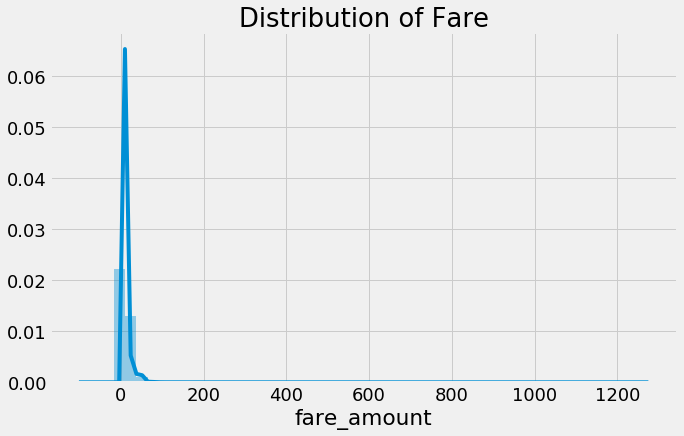

In [7]:
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount']);
plt.title('Distribution of Fare');

In [8]:
print(f"There are {len(data[data['fare_amount'] < 0])} negative fares.")
print(f"There are {len(data[data['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(data[data['fare_amount'] > 100])} fares greater than $100.")

There are 262 negative fares.
There are 160 $0 fares.
There are 2338 fares greater than $100.


### Remove Outliers

Remove any fare  < $2.5.  

Remove any fare > $100



In [0]:
data = data[data['fare_amount'].between(left = 2.5, right = 100)]

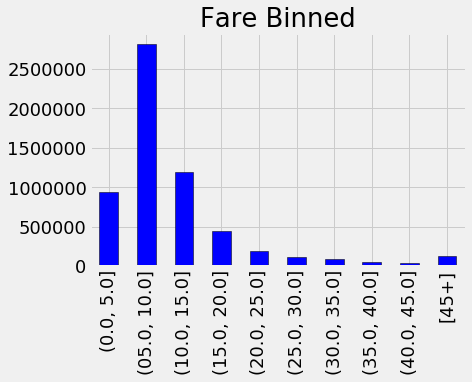

In [10]:
# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype('str')

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5.0, 10.0]', 'fare-bin'] = '(05.0, 10.0]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

### Percentile of Distribution
Empirical Cumulative Distribution Function Plot




In [0]:
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

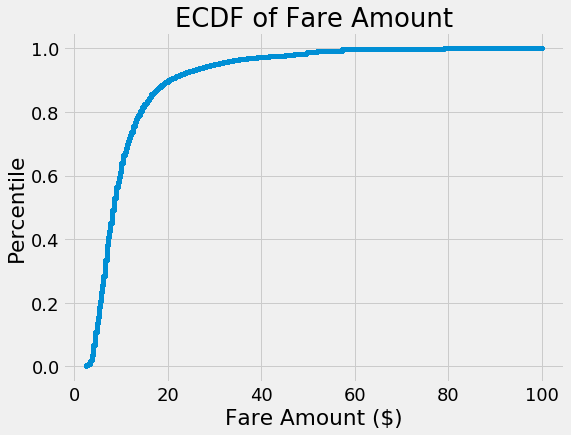

In [12]:
xs, ys = ecdf(data['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');


## Passenger Counts



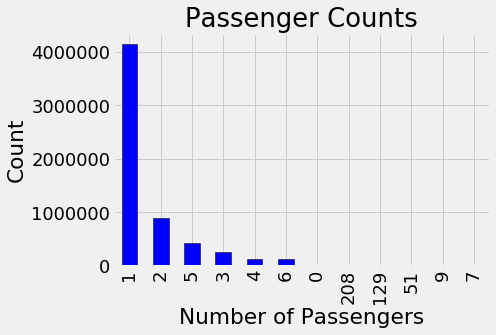

In [13]:
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

### Remove any passenger >  6

In [0]:
data = data.loc[data['passenger_count'] < 6]

## Latitude, Longitude


In [15]:
print(f'Initial Observations: {data.shape[0]}')

Initial Observations: 5870327


In [16]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(data[col], 2.5), 2):5} \t 97.5% = {round(np.percentile(data[col], 97.5), 2)}')

Pickup_latitude  : 2.5% = 40.64 	 97.5% = 40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% = -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% = 40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% = -73.78


In [17]:
# Remove latitude and longtiude outliers
data = data.loc[data['pickup_latitude'].between(40, 42)]
data = data.loc[data['pickup_longitude'].between(-75, -72)]
data = data.loc[data['dropoff_latitude'].between(40, 42)]
data = data.loc[data['dropoff_longitude'].between(-75, -72)]

print(f'New number of observations: {data.shape[0]}')

New number of observations: 5747234


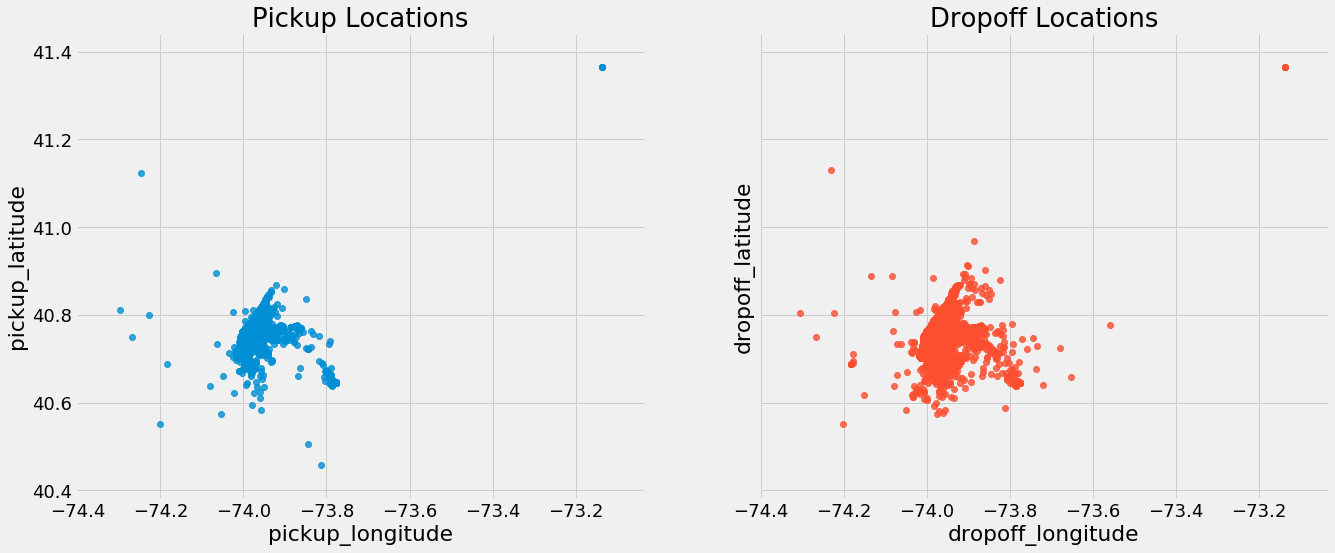

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

### Rides on Map of NYC

The map was extracted from OpenStreetMaps (https://www.openstreetmap.org/export#map=12/40.7250/-73.8999)

In [0]:
# load image of NYC map
# BB = (-74.5, -72.8, 40.5, 41.8)
# nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

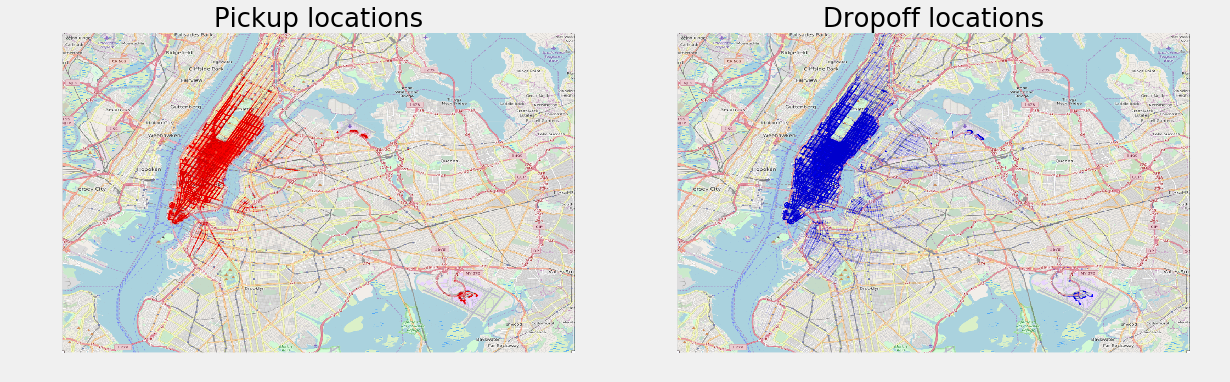

In [20]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(data.sample(1_000_000, random_state = RSEED), 
            BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

 There are more rides ending outside Manhattan than inside.



In [21]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(data['fare-bin'].unique())}
color_mapping

{'(0.0, 5.0]': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 '(05.0, 10.0]': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 '(10.0, 15.0]': (0.2, 0.6274509803921569, 0.17254901960784313),
 '(15.0, 20.0]': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765),
 '(20.0, 25.0]': (0.984313725490196, 0.6039215686274509, 0.6),
 '(25.0, 30.0]': (1.0, 0.4980392156862745, 0.0),
 '(30.0, 35.0]': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 '(35.0, 40.0]': (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 '(40.0, 45.0]': (0.41568627450980394,
  0.23921568627450981,
  0.6039215686274509),
 '[45+]': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883)}

In [0]:
data['color'] = data['fare-bin'].map(color_mapping)
plot_data = data.sample(1_000_000, random_state = RSEED)

### Plotting the pickup and dropoff locations

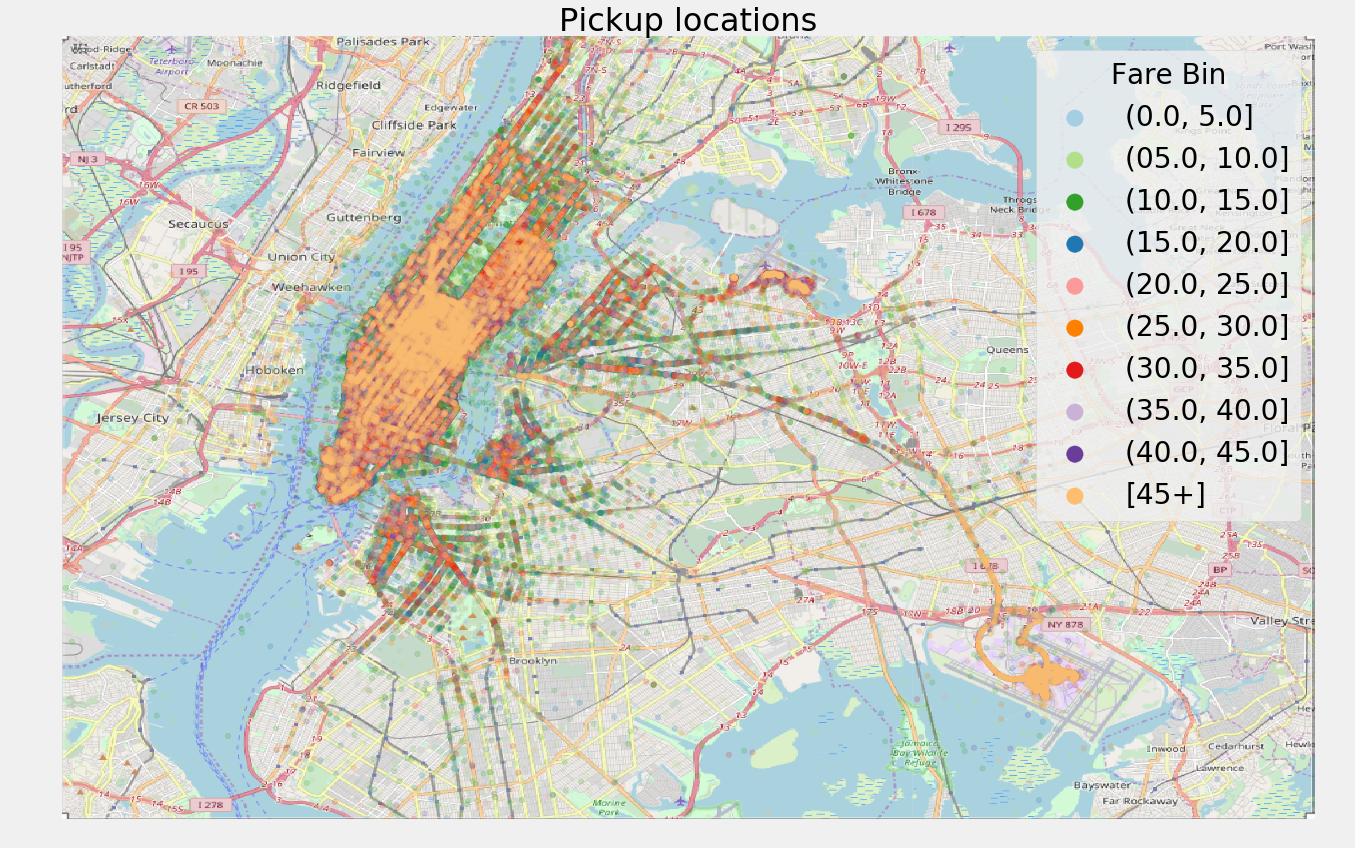

In [23]:
BB = BB_zoom

fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_data.groupby('fare-bin'):
    # Set the zorder to 1 to plot on top of map
    axs.scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Pickup locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

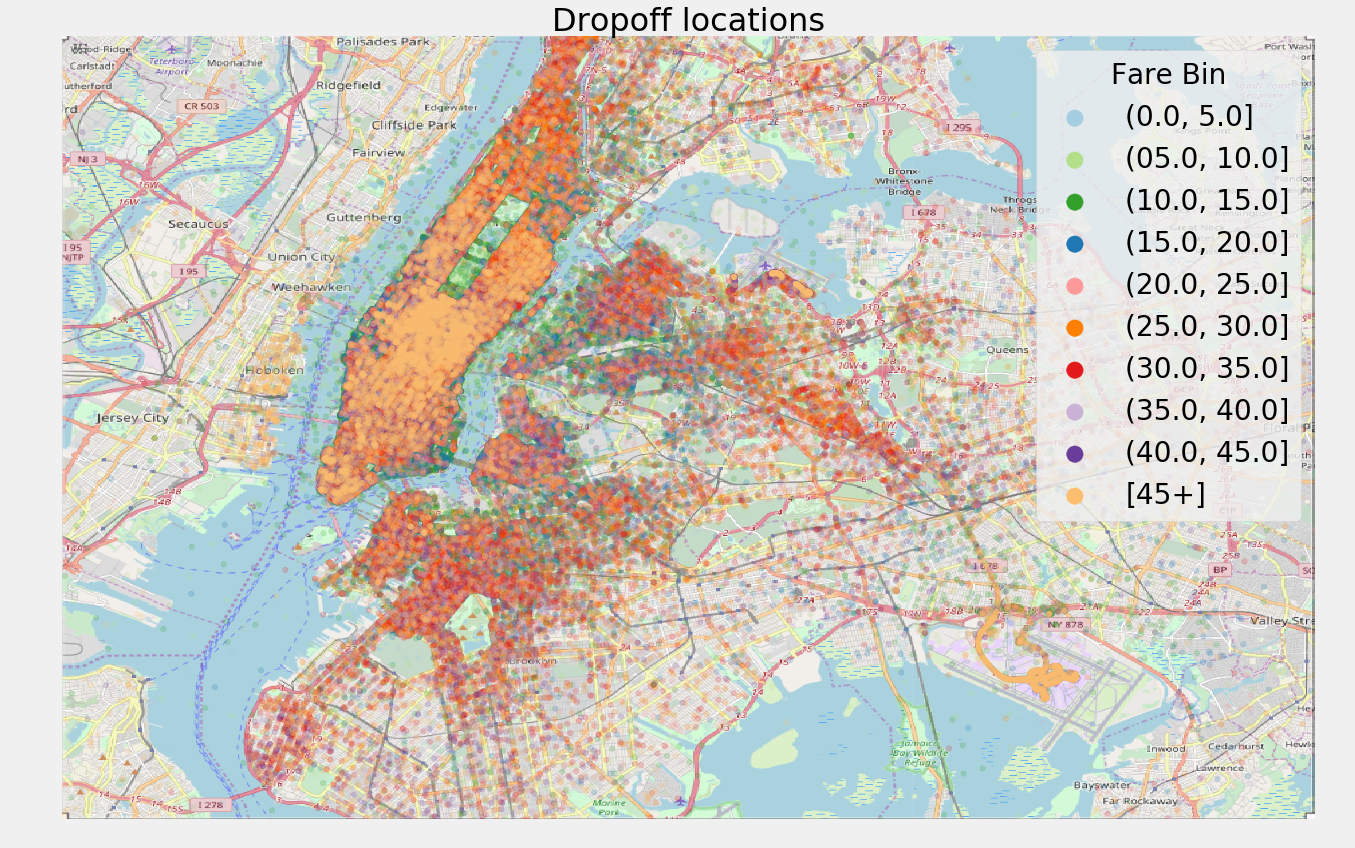

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in plot_data.groupby('fare-bin'):
    axs.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, 
                alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Dropoff locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

# Feature Engineering  I:  Distance



## Absolute latitude difference vs Absolute longitude difference

In [0]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

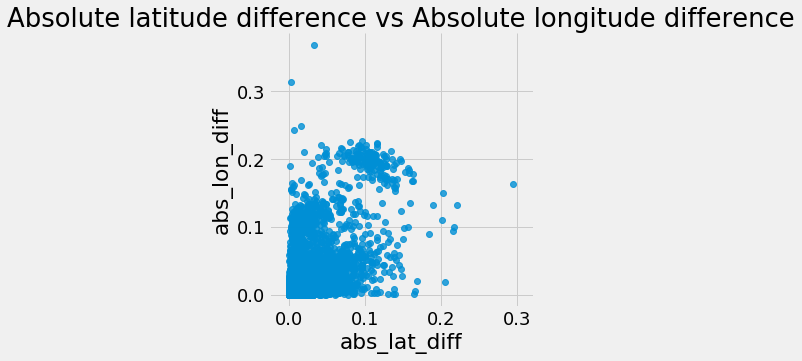

In [26]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False,
           data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

In [27]:
no_diff = data[(data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)]
no_diff.shape

(61248, 11)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


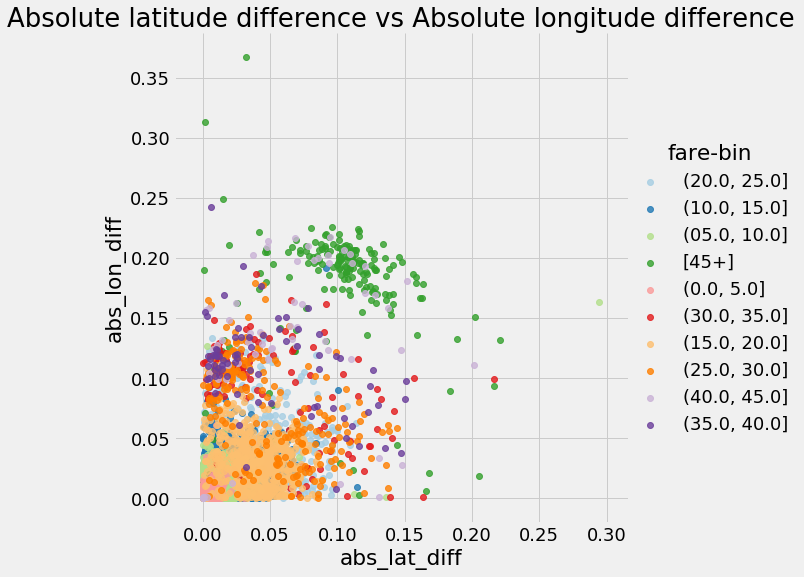

In [28]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette=palette,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


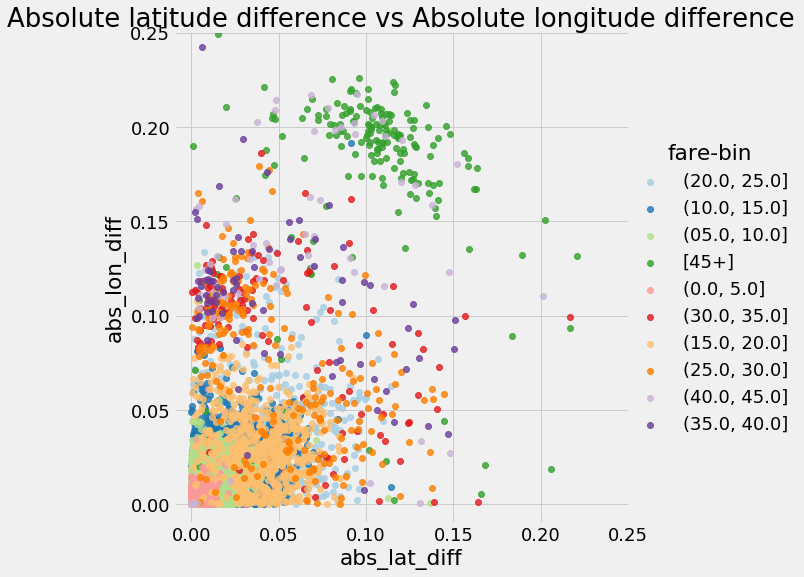

In [29]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8, palette = palette,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

## Manhattan Distance

In [0]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [31]:
minkowski_distance(0, 3, 0, 4, 1)

7.0

In [32]:
minkowski_distance(0, 3, 0, 4, 2)

5.0

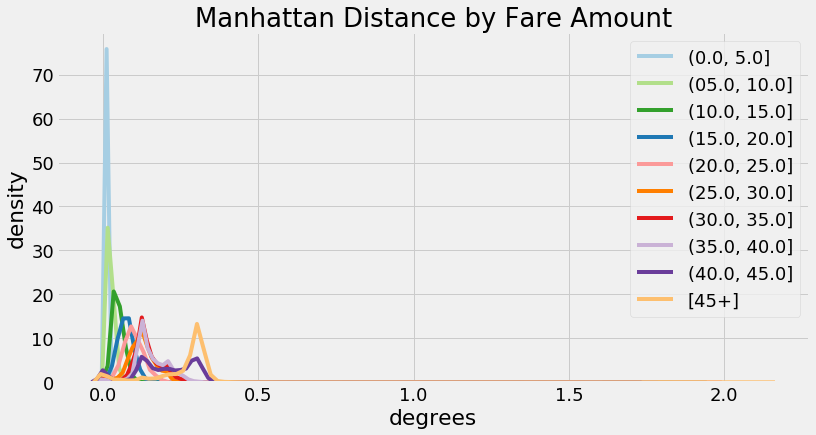

In [33]:
data['manhattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['manhattan'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Manhattan Distance by Fare Amount');

## Euclidean Distance

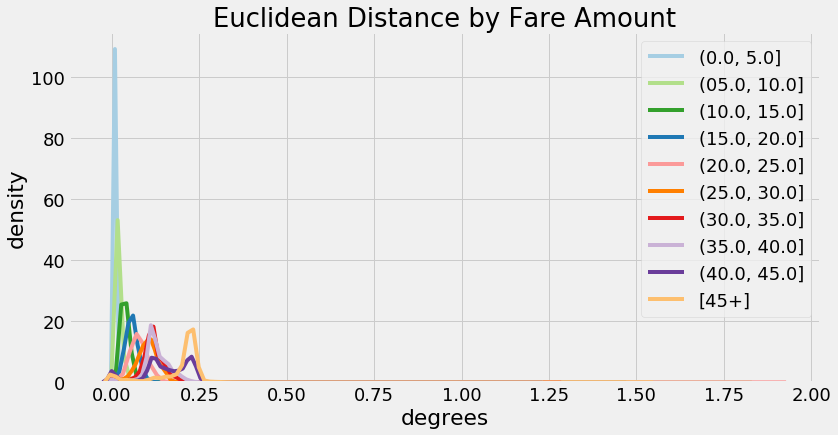

In [34]:
data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['euclidean'], label = f'{f}', color = list(grouped['color'])[0]);

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');

These features do seem to have some differences between the different fare amounts, so they might be helpful in predicting the fare. 

In [35]:
data.groupby('fare-bin')['euclidean'].agg(['mean', 'count'])

mean    count
fare-bin                   
(0.0, 5.0]   0.009   895790
(05.0, 10.0] 0.019  2702410
(10.0, 15.0] 0.037  1146597
(15.0, 20.0] 0.055   419833
(20.0, 25.0] 0.075   181668
(25.0, 30.0] 0.101   113834
(30.0, 35.0] 0.117    83331
(35.0, 40.0] 0.128    48247
(40.0, 45.0] 0.153    39995
[45+]        0.191   115529

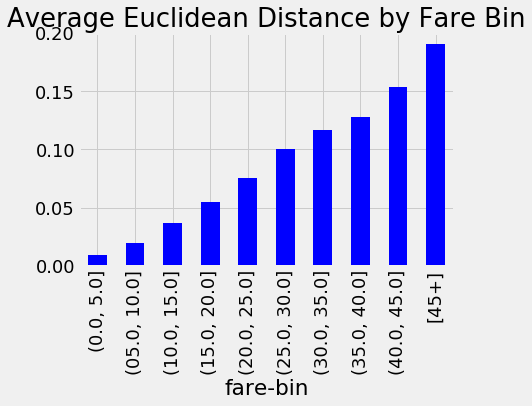

In [36]:
data.groupby('fare-bin')['euclidean'].mean().plot.bar(color = 'b');
plt.title('Average Euclidean Distance by Fare Bin');

The passenger count distribution colored by the fare bin.

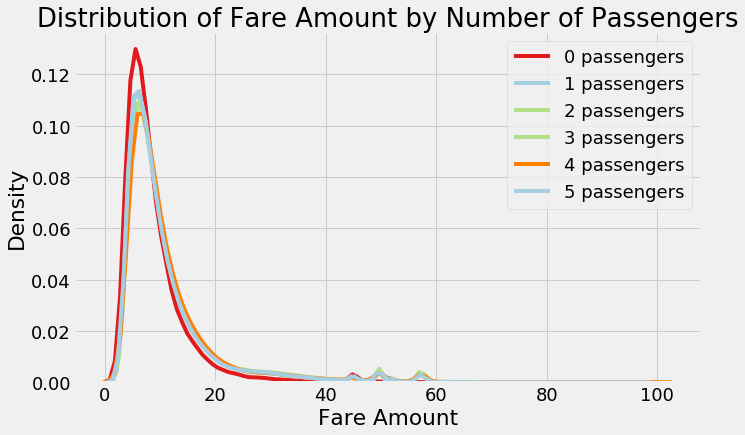

In [37]:
plt.figure(figsize = (10, 6))

for p, grouped in data.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = f'{p} passengers', color = list(grouped['color'])[0]);
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

There does not appear to be much difference between the number of passengers. To get a more accurate picture, we can calculate the actual stats.

In [38]:
data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

mean    count
passenger_count                
0                8.965    20716
1               11.141  4060348
2               11.762   868249
3               11.507   257836
4               11.719   124745
5               11.193   415340

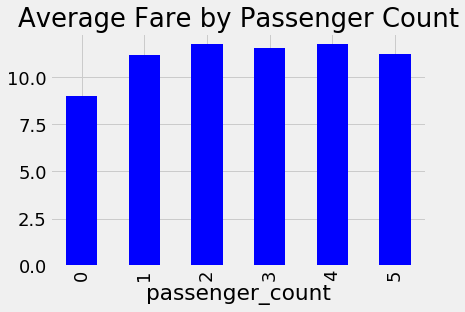

In [39]:
data.groupby('passenger_count')['fare_amount'].mean().plot.bar(color = 'b');
plt.title('Average Fare by Passenger Count');

There is a small but noticeable difference in the average fare by the number of passengers.

## Test data: create same features

For the test data, we need to save the `key` column for making submissions. 

In [40]:
test = pd.read_csv('/content/test.csv', parse_dates = ['pickup_datetime'])

# Create absolute differences
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

test.describe()

pickup_longitude  pickup_latitude  ...  abs_lat_diff  abs_lon_diff
count          9914.000         9914.000  ...      9914.000      9914.000
mean            -73.975           40.751  ...         0.022         0.023
std               0.043            0.034  ...         0.026         0.037
min             -74.252           40.573  ...         0.000         0.000
25%             -73.993           40.736  ...         0.007         0.006
50%             -73.982           40.753  ...         0.015         0.013
75%             -73.968           40.767  ...         0.028         0.025
max             -72.987           41.710  ...         0.633         0.849

[8 rows x 7 columns]

In [0]:
test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

## Haversine distance



In [0]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [0]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

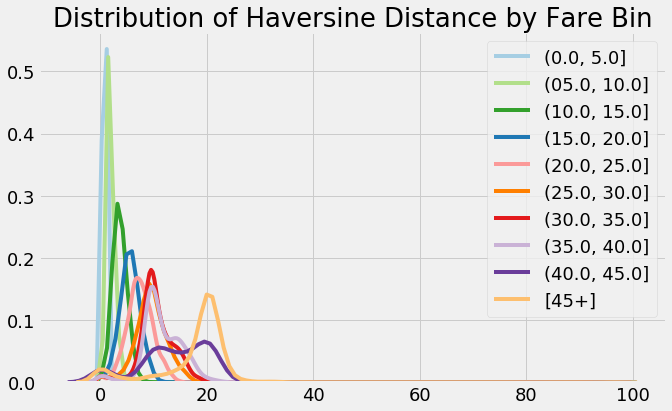

In [44]:
subset = data.sample(100000, random_state=RSEED)

plt.figure(figsize = (10, 6))

for f, grouped in subset.groupby('fare-bin'):
    sns.kdeplot(grouped['haversine'], label = f'{f}', color = list(grouped['color'])[0]);
    
plt.title('Distribution of Haversine Distance by Fare Bin');

In [45]:
data.groupby('fare-bin')['haversine'].agg(['mean', 'count'])

mean    count
fare-bin                    
(0.0, 5.0]    0.910   895790
(05.0, 10.0]  1.933  2702410
(10.0, 15.0]  3.701  1146597
(15.0, 20.0]  5.574   419833
(20.0, 25.0]  7.517   181668
(25.0, 30.0]  9.514   113834
(30.0, 35.0] 10.726    83331
(35.0, 40.0] 11.620    48247
(40.0, 45.0] 13.950    39995
[45+]        17.488   115529

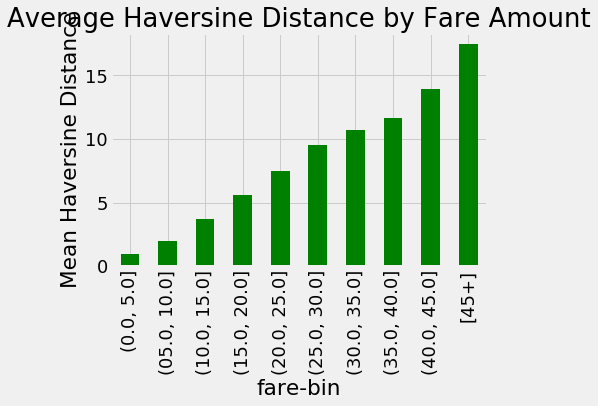

In [46]:
data.groupby('fare-bin')['haversine'].mean().sort_index().plot.bar(color = 'g');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

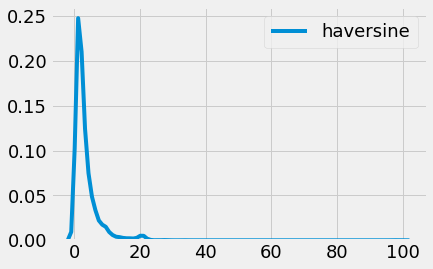

In [47]:
sns.kdeplot(test['haversine']);

The test distribution seems to be similar to the training distribution.

As a final step, we can find the correlations between distances and fares.

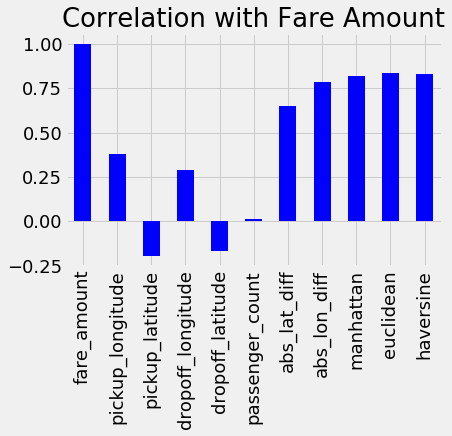

In [48]:
corrs = data.corr()
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');




# Linear Regression



In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

## Create Training and Validation Set



In [0]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

## Error Metrics:   RSME & MAPE


* __Root mean squared error__: the metric used by the competition
* __Mean absolute percentage error__: the average percentage error of the predictions


In [0]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

## Baseline performance (3 features)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

In [53]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      '\tabs_lon_diff coef:', round(lr.coef_[1], 4),
      '\tpassenger_count coef:', round(lr.coef_[2], 4))

Intercept 5.05
abs_lat_diff coef:  114.9458 	abs_lon_diff coef: 164.2896 	passenger_count coef: 0.0187


In [54]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.32 	 mape = 28.0
Validation: rmse = 5.38 	 mape = 28.06


## Performance I:  Baseline + Haversine (4 Features)


In [55]:
lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.0 	 mape = 24.51
Validation: rmse = 5.08 	 mape = 24.57


In [56]:
print(lr.intercept_)
print(lr.coef_)

4.539809455142508
[ 4.28769823e+00 -2.42424856e+02 -1.05225758e+02  1.08242784e-02]



## Collinear Features
.

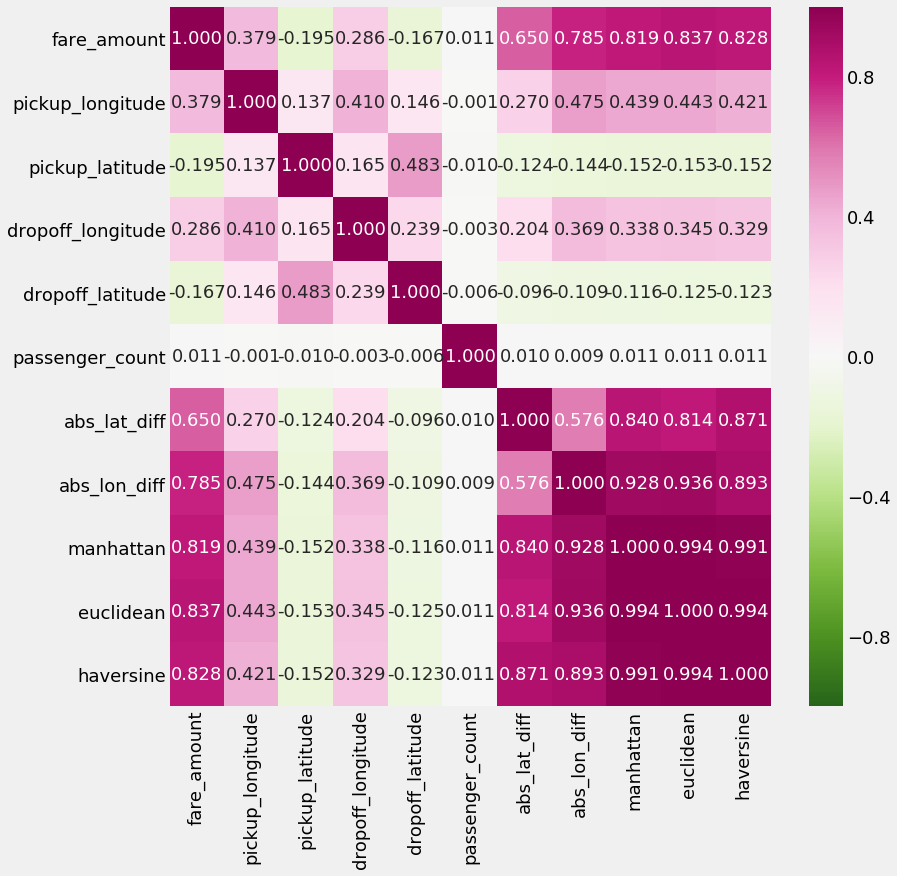

In [57]:
corrs = data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

# Random Forest


In [58]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=1,
                      warm_start=False)

## Performance I: Baseline + Haversine (4 features)

In [59]:
evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   19.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training:   rmse = 3.61 	 mape = 20.54
Validation: rmse = 4.2 	 mape = 22.08


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.1s finished


## Include more Features



In [0]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 20, max_depth = 20,
                                           n_jobs = -1),
             return_model = False):
    """Train and evaluate the random forest using the given set of features."""
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    if return_model:
        return sub, feature_importances, model
    
    return sub, feature_importances

In [61]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'color', 'abs_lat_diff', 'abs_lon_diff', 'manhattan', 'euclidean',
       'haversine'],
      dtype='object')

## Performance II:  (8 features)

In [62]:
# Evaluate using 8 features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

Training:   rmse = 3.09 	 mape = 18.4
Validation: rmse = 3.71 	 mape = 19.93




#### Feature Importances

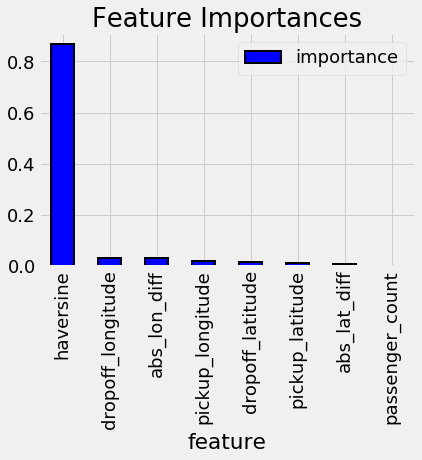

In [63]:
fi.plot.bar(color = 'b', edgecolor = 'k', linewidth = 2);
plt.title('Feature Importances');

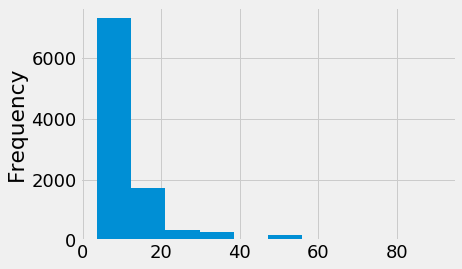

In [64]:
sub.to_csv('sub_rf_8_features.csv', index = False)
sub['fare_amount'].plot.hist();

# Feature Engineering II: Time




### Fractional Time Variables


In [0]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [66]:
print(data['pickup_datetime'].min())
print(test['pickup_datetime'].min())

2009-01-01 00:00:46+00:00
2009-01-01 11:04:24+00:00


In [67]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.head()

pickup_datetime  pickup_longitude  ...  pickup_frac_year  pickup_Elapsed
0 2015-01-27 13:08:24+00:00           -73.973  ...             0.075   191596058.000
1 2015-01-27 13:08:24+00:00           -73.987  ...             0.075   191596058.000
2 2011-10-08 11:53:44+00:00           -73.983  ...             0.769    87306778.000
3 2012-12-01 21:12:12+00:00           -73.981  ...             0.918   123628286.000
4 2012-12-01 21:12:12+00:00           -73.966  ...             0.918   123628286.000

[5 rows x 28 columns]

In [68]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.describe()

pickup_longitude  pickup_latitude  ...  pickup_frac_year  pickup_Elapsed
count          9914.000         9914.000  ...          9914.000        9914.000
mean            -73.975           40.751  ...             0.531   105528198.549
std               0.043            0.034  ...             0.278    55864049.590
min             -74.252           40.573  ...             0.003       39818.000
25%             -73.993           40.736  ...             0.315    59252977.000
50%             -73.982           40.753  ...             0.533    96795134.000
75%             -73.968           40.767  ...             0.758   158694421.000
max             -72.987           41.710  ...             0.999   204926584.000

[8 rows x 26 columns]

## Explore Time Variables


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


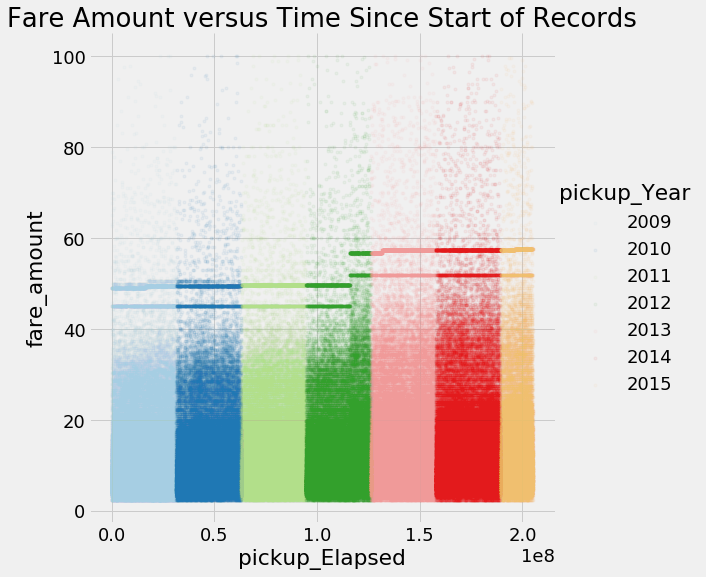

In [69]:
sns.lmplot('pickup_Elapsed', 'fare_amount', hue = 'pickup_Year', palette=palette, size = 8,
           scatter_kws= {'alpha': 0.05}, markers = '.', fit_reg = False,
           data = data.sample(1000000, random_state=RSEED));
plt.title('Fare Amount versus Time Since Start of Records');

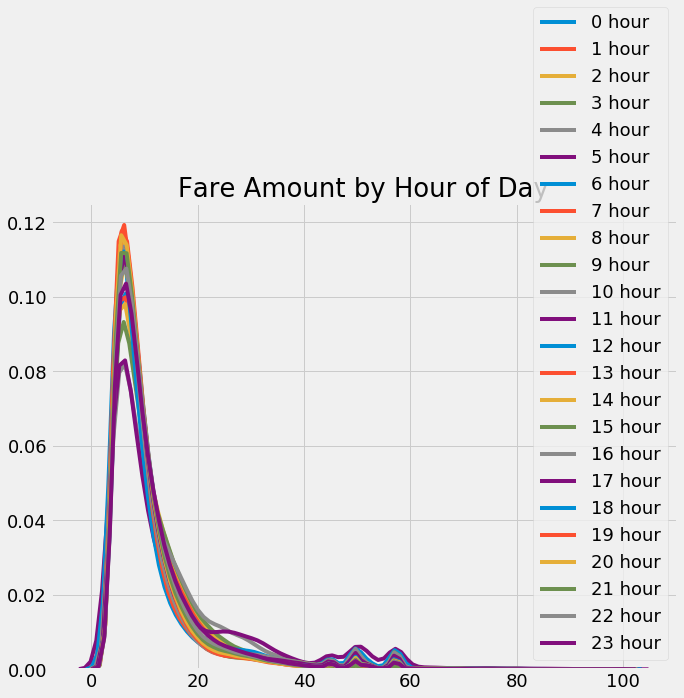

In [70]:
plt.figure(figsize = (10, 8))
for h, grouped in data.groupby('pickup_Hour'):
    sns.kdeplot(grouped['fare_amount'], label = f'{h} hour');
plt.title('Fare Amount by Hour of Day');

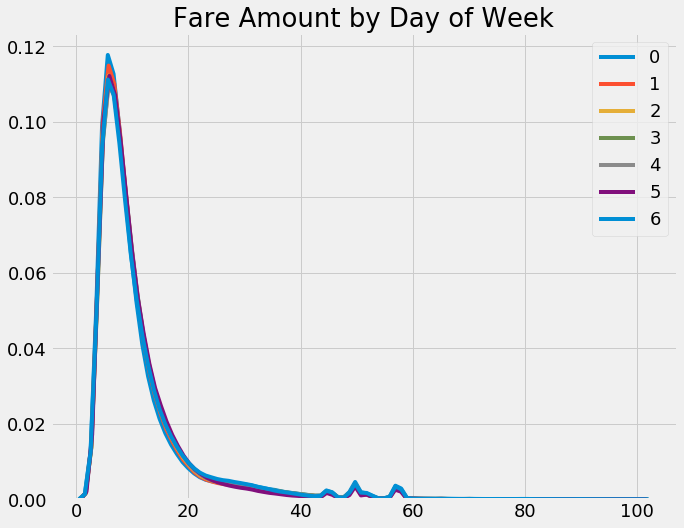

In [71]:
plt.figure(figsize = (10, 8))
for d, grouped in data.groupby('pickup_Dayofweek'):
    sns.kdeplot(grouped['fare_amount'], label = f'{d}')
plt.title('Fare Amount by Day of Week');


### Fractional Time Plots


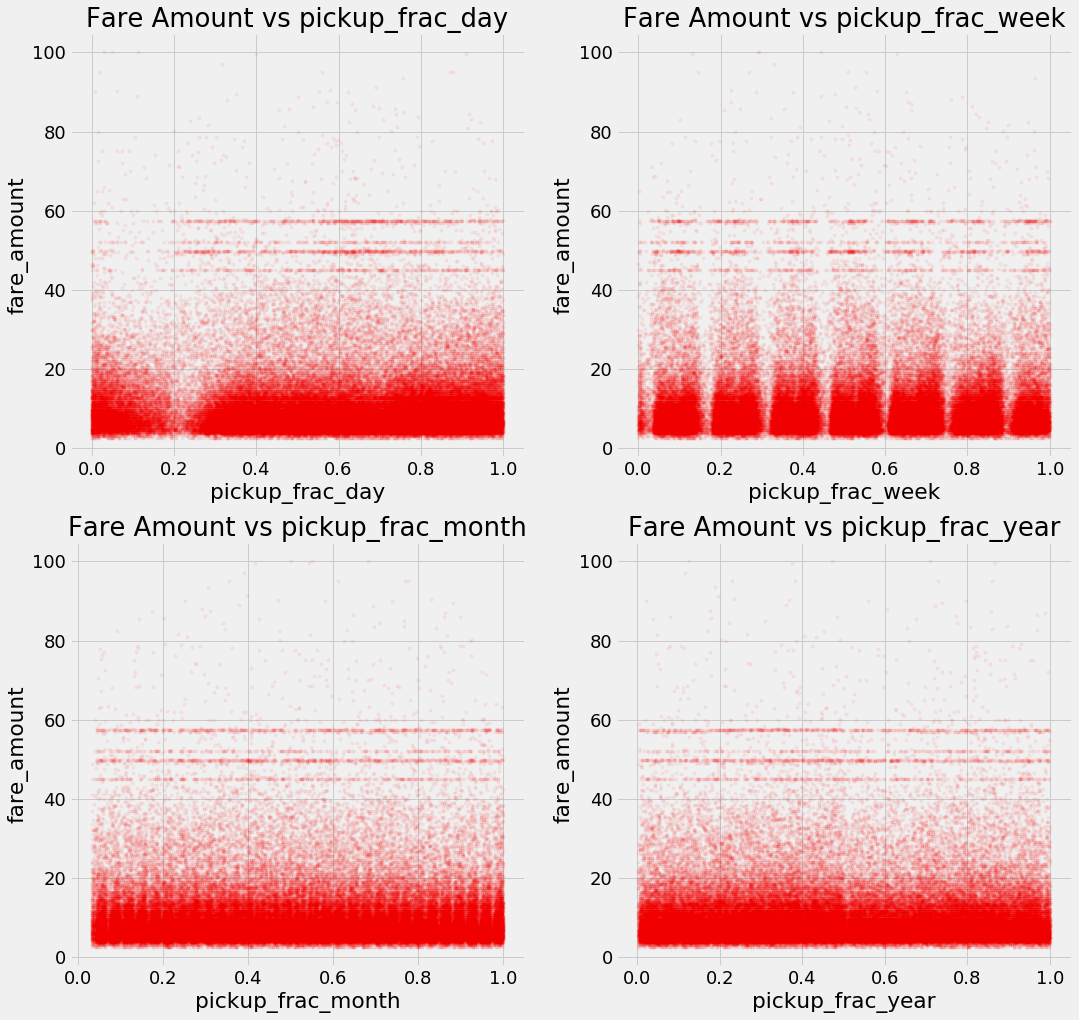

In [72]:
fig, axes = plt.subplots(2, 2, figsize = (16, 16))
axes = axes.flatten()

# Plot each of the fractional times
for i, d in enumerate(['day', 'week', 'month', 'year']):
    ax = axes[i]
    sns.regplot(f'pickup_frac_{d}', 'fare_amount', 
                data = data.sample(100000, random_state = RSEED), 
                fit_reg = False, scatter_kws = {'alpha': 0.05}, marker = '.', ax = ax,
                color = 'r')
    
    ax.set_title(f'Fare Amount vs pickup_frac_{d}')

In [73]:
fare_counts = data.groupby('fare_amount')['haversine'].agg(['count', pd.Series.nunique]).sort_values('count', ascending = False)
fare_counts.head()

count    nunique
fare_amount                   
6.500        279618 276782.000
4.500        236868 233333.000
8.500        215510 213790.000
5.300        170469 168154.000
5.700        170046 167876.000

#### Correlations with Target


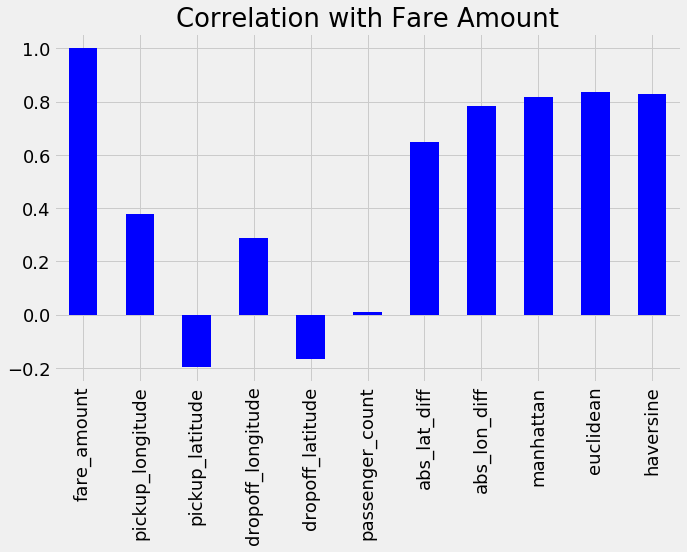

In [74]:
# corrs = data.corr()
corrs['fare_amount'].plot.bar(color = 'b', figsize = (10, 6));
plt.title('Correlation with Fare Amount');

# Final Performance


## Using 12 Features


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

In [0]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

In [77]:
len(features)

12

### Randon Frorest

In [78]:
# Test using the features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = features)

Training:   rmse = 2.65 	 mape = 15.44
Validation: rmse = 3.38 	 mape = 17.15


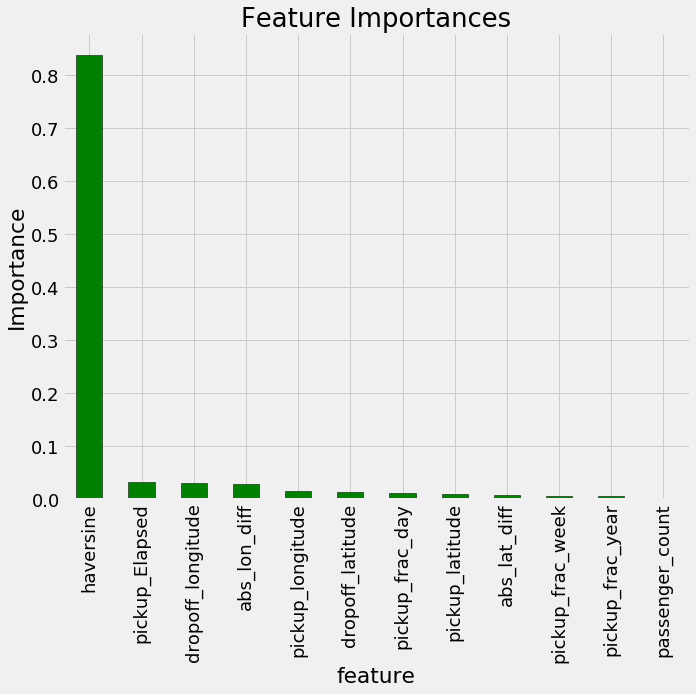

In [79]:
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [0]:
# Save submission
sub.to_csv('sub_rf_12_features.csv', index = False)

### Linear Regression

In [81]:
lr = LinearRegression()

# Fit and evaluate
lr.fit(X_train[features], y_train)
evaluate(lr, features, X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.85 	 mape = 23.81
Validation: rmse = 4.92 	 mape = 23.82


## Using All Features (27)


In [82]:
features = list(data.columns)

for f in ['pickup_datetime', 'fare_amount', 'fare-bin', 'color']:
    features.remove(f)
    
len(features)

27

### Random Forest

In [83]:
# Test using all the features
sub, fi, random_forest = model_rf(X_train, X_valid, y_train, y_valid, test, 
                                  features = features, return_model = True)

Training:   rmse = 2.66 	 mape = 15.5
Validation: rmse = 3.39 	 mape = 17.22


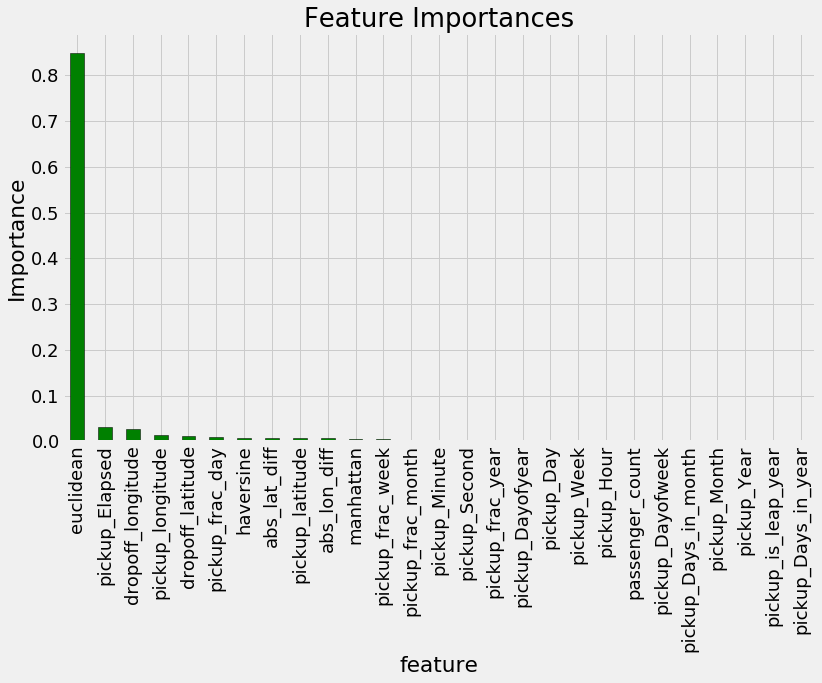

In [84]:
plt.figure(figsize = (12, 7))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [0]:
sub.to_csv('sub_rf_all_features.csv', index = False)

### Visualization Actual vs Predicted


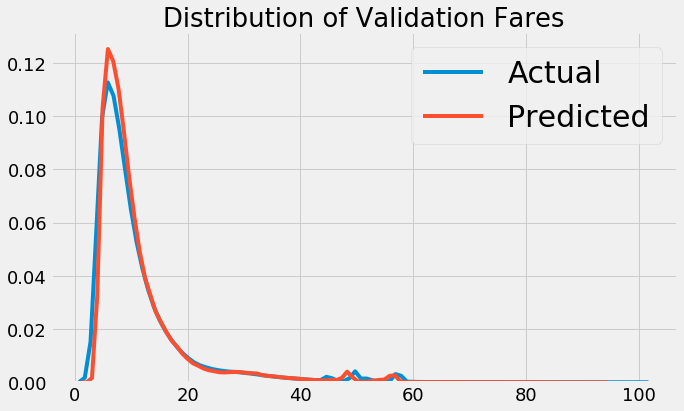

In [86]:
valid_preds = random_forest.predict(X_valid[features])

plt.figure(figsize = (10, 6))
sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(valid_preds, label = 'Predicted')
plt.legend(prop = {'size': 30})
plt.title("Distribution of Validation Fares");

### ECDF data

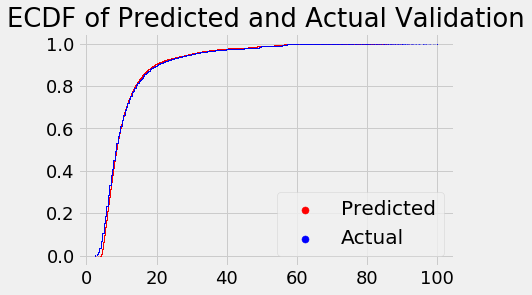

In [87]:
# Generate ecdf data
xv, yv = ecdf(valid_preds)
xtrue, ytrue = ecdf(y_valid)

# Plot the ecdfs on same plot
plt.scatter(xv, yv, s = 0.02,  c = 'r', marker = '.', label = 'Predicted')
plt.scatter(xtrue, ytrue, s = 0.02, c = 'b', marker = '.', label = 'Actual')
plt.title('ECDF of Predicted and Actual Validation')

plt.legend(markerscale = 100, prop = {'size': 20});

In [88]:
analyze = pd.DataFrame({'predicted': valid_preds, 'actual': y_valid})
analyze.describe()

predicted      actual
count 1000000.000 1000000.000
mean       11.268      11.262
std         8.742       9.353
min         2.791       2.500
25%         6.337       6.000
50%         8.540       8.500
75%        12.422      12.500
max        92.855     100.000

In [89]:
!ls -al *.csv

-rw-r--r-- 1 root root     343271 Jul 25  2018 sample_submission.csv
-rw-r--r-- 1 root root     464506 May 24 08:37 sub_rf_12_features.csv
-rw-r--r-- 1 root root     464543 May 24 08:11 sub_rf_8_features.csv
-rw-r--r-- 1 root root     464589 May 24 09:21 sub_rf_all_features.csv
-rw-r--r-- 1 root root     983020 Jul 25  2018 test.csv
-rw-r--r-- 1 root root 5697178298 Jul 25  2018 train.csv
